In [57]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [58]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [59]:
# Load data
data_train = pd.read_csv('../Dataset/train_data.csv')
data_test = pd.read_csv('../Dataset/test_data.csv')

In [60]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [61]:
# Text preprocessing
def wordopt(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Resources/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [62]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_test
X_test = X_test.apply(preprocess)

In [63]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_test_processed = [' '.join(tokens) for tokens in X_test]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (2103, 27707)
Shape of X_test_tfidf: (902, 27707)


In [64]:
basemodel_mnb = joblib.load('../Models/Base/basemodel_MNB_grid.joblib')
basemodel_lr = joblib.load('../Models/Base/basemodel_LR_grid.joblib')
basemodel_rf = joblib.load('../Models/Base/basemodel_RF_grid.joblib')
basemodel_knn = joblib.load('../Models/Base/basemodel_KNN_grid.joblib')
basemodel_svm = joblib.load('../Models/Base/basemodel_SVM_grid.joblib')

base_models = [
    basemodel_mnb, 
    basemodel_lr,
    basemodel_rf,
    basemodel_knn,
    basemodel_svm
]

base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

stackmodel_lr = joblib.load('../Models/Grid/grid_lr.joblib')
stackmodel_rf = joblib.load('../Models/Grid/grid_rf_5_final.joblib')
stackmodel_svm = joblib.load('../Models/Grid/grid_svm.joblib')
stackmodel_mlp = joblib.load('../Models/Grid/grid_mlp_3.joblib')


In [79]:
stack_lr = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=stackmodel_lr, cv='prefit')
stack_rf = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=stackmodel_rf, cv='prefit')
stack_svm = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=stackmodel_svm, )
stack_mlp = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=stackmodel_mlp, )


In [80]:
# stack_lr.fit(X_train_tfidf, y_train)

In [81]:
# stack_rf.fit(X_train_tfidf, y_train)

In [82]:
stack_svm.fit(X_train_tfidf, y_train)

StackingClassifier(estimators=[('MNB',
                                MultinomialNB(alpha=0.1, fit_prior=False)),
                               ('LR',
                                LogisticRegression(C=100, solver='liblinear')),
                               ('RF',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('KNN',
                                KNeighborsClassifier(metric='euclidean')),
                               ('SVM',
                                SVC(C=10, degree=2, kernel='linear',
                                    probability=True))],
                   final_estimator=GridSearchCV(cv=5, estimator=SVC(),
                                                n_jobs=-1,
                                                param_grid={'C': [0.1, 1, 10],
                                                            'class_weight': [None,
                                                                             'balanced'],
                                                            'degree': [2, 3, 4],
                                                            'gamma': ['scale',
                                                                      'auto'],
                                                            'kernel': ['rbf'],
                                                            'probability': [True,
                                                                            False]},
                                                scoring='accuracy'))

In [83]:
stack_mlp.fit(X_train_tfidf, y_train)

StackingClassifier(estimators=[('MNB',
                                MultinomialNB(alpha=0.1, fit_prior=False)),
                               ('LR',
                                LogisticRegression(C=100, solver='liblinear')),
                               ('RF',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('KNN',
                                KNeighborsClassifier(metric='euclidean')),
                               ('SVM',
                                SVC(C=10, degree=2, kernel='linear',
                                    probability=True))],
                   final_estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                                 hidden_layer_sizes=(10,),
                                                 max_iter=300))

In [84]:
# stackmodels = [
#     (stack_lr, 'Logistic Regression'),
#     (stack_rf, 'Random Forest'),
#     (stack_svm, 'Support Vector Machine'),
#     (stack_mlp, 'Multi-layer Perceptron'),
    # ]

In [86]:
# scores_lr = cross_val_score(stack_lr, X_train_tfidf, y_train, cv=5, scoring='accuracy')

In [87]:
# scores_rf = cross_val_score(stack_rf, X_train_tfidf, y_train, cv=5, scoring='accuracy')

In [88]:
scores_svm = cross_val_score(stack_svm, X_train_tfidf, y_train, cv=5, scoring='accuracy')

In [89]:
scores_mlp = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='accuracy')

In [97]:
scores_mlp_precision = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='precision')
scores_mlp_recall = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='recall')
scores_mlp_f1 = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='f1')
scores_mlp_roc_auc = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='roc_auc')
scores_mlp_neg_root = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='neg_root_mean_squared_log_error')
scores_mlp_max_error = cross_val_score(stack_mlp, X_train_tfidf, y_train, cv=5, scoring='max_error')

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [90]:
# mean_score_lr = scores_lr.mean()
# mean_score_rf = scores_rf.mean()
mean_score_svm = scores_svm.mean()
mean_score_mlp = scores_mlp.mean()

In [100]:
metrics_df = pd.DataFrame( columns=['Mean Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Neg Root', 'Max Error',])
metrics_df.loc['Multilayer Perceptron'] = [
    mean_score_mlp, 
    scores_mlp_precision.mean(),
    scores_mlp_recall.mean(),
    scores_mlp_f1.mean(),
    scores_mlp_roc_auc.mean(),
    scores_mlp_neg_root.mean(),
    scores_mlp_max_error.mean()
]

print(metrics_df)

                       Mean Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Multilayer Perceptron        0.95388   0.959824  0.951703   0.95566  0.992785   

                       Neg Root  Max Error  
Multilayer Perceptron -0.146266       -1.0  


In [110]:
test_scores_mlp_acc = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='accuracy')
test_scores_mlp_precision = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='precision')
test_scores_mlp_recall = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='recall')
test_scores_mlp_f1 = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='f1')
test_scores_mlp_roc_auc = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='roc_auc')
test_scores_mlp_neg_root = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='neg_root_mean_squared_log_error')
test_scores_mlp_max_error = cross_val_score(stack_mlp, X_test_tfidf, y_test, cv=5, scoring='max_error')

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the opti

In [112]:
print ('TESTING')
metrics_df = pd.DataFrame( columns=['Mean Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Neg Root', 'Max Error',])
metrics_df.loc['Multilayer Perceptron'] = [
    test_scores_mlp_acc.mean(), 
    test_scores_mlp_precision.mean(),
    test_scores_mlp_recall.mean(),
    test_scores_mlp_f1.mean(),
    test_scores_mlp_roc_auc.mean(),
    test_scores_mlp_neg_root.mean(),
    test_scores_mlp_max_error.mean()
]

print(metrics_df)

TESTING
                       Mean Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Multilayer Perceptron       0.942339   0.948441  0.931697  0.938576  0.983103   

                       Neg Root  Max Error  
Multilayer Perceptron -0.164628       -1.0  


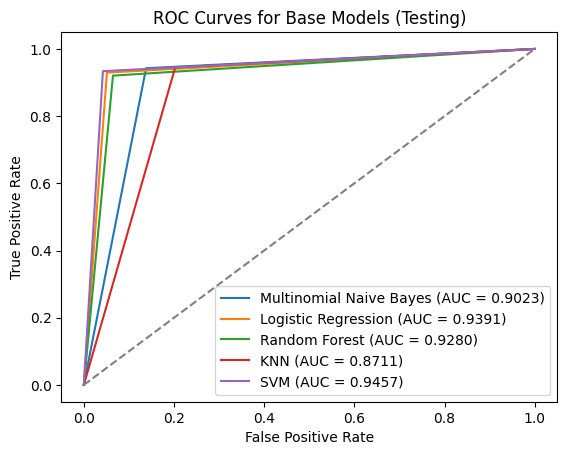

In [133]:

basemodels = [
    ('Multinomial Naive Bayes', basemodel_mnb),
    ('Logistic Regression', basemodel_lr),
    ('Random Forest', basemodel_rf),
    ('KNN', basemodel_knn),
    ('SVM', basemodel_svm),

]
# Initialize lists to store ROC curve data
plt.figure()

    
for name, model in basemodels:
    # model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models (Testing)')
plt.legend()
plt.show()

In [117]:
stack_y_pred = stack_mlp.predict(X_test_tfidf)
stack_y_prob = stack_mlp.predict_proba(X_test_tfidf)[:, 1]
stack_accuracy = accuracy_score(y_test, stack_y_pred)
stack_precision = precision_score(y_test, stack_y_pred)
stack_recall = recall_score(y_test, stack_y_pred)
stack_f1 = f1_score(y_test, stack_y_pred)
stack_auc = roc_auc_score(y_test, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall: {stack_recall:.4f}")
print(f"F1 Score: {stack_f1:.4f}")
print(f"AUC: {stack_auc:.4f}")
print(f"Classification Report:\n{classification_report(y_test, stack_y_pred)}")

Metrics for Stacking Model:
Accuracy: 0.9545
Precision: 0.9558
Recall: 0.9536
F1 Score: 0.9547
AUC: 0.9884
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       449
           1       0.96      0.95      0.95       453

    accuracy                           0.95       902
   macro avg       0.95      0.95      0.95       902
weighted avg       0.95      0.95      0.95       902



In [118]:
joblib.dump(stack_mlp, '../Models/Stack/stack_mlp_4_954.joblib')

['../Models/Stack/stack_mlp_4_954.joblib']

In [91]:
metrics_df = pd.DataFrame( columns=['Mean Accuracy'])
metrics_df.loc['Stacking Model'] = [""]

    
# metrics_df.loc['Logistic Regression'] = [mean_score_lr]
# metrics_df.loc['Random Forest'] = [mean_score_rf]
metrics_df.loc['Support Vector Machine'] = [mean_score_svm]
metrics_df.loc['Multilayer Perceptron'] = [mean_score_mlp]


# Display the comparison table
print("Comparison of Models: (TRAINING)")
print(metrics_df)

Comparison of Models: (TRAINING)
                       Mean Accuracy
Stacking Model                      
Support Vector Machine      0.960537
Multilayer Perceptron        0.95388


In [92]:
# joblib.dump(scores_lr, '../Models/Result/stack_lr_crossvalscore')
# joblib.dump(scores_rf, '../Models/Result/stack_rf_crossvalscore')
# joblib.dump(scores_svm, '../Models/Result/stack_svm_crossvalscore')
# joblib.dump(scores_mlp, '../Models/Result/stack_mlp_crossvalscore')

In [94]:
score = joblib.load('../Models/Result/stack_mlp_crossvalscore')
                    
print(score.mean())

0.9591132224861442
